##  Preliminary Result

In [1]:
library(tidyverse)
library(repr)
library(infer)
library(moderndive)
library(nycflights13)
library(ggplot2movies)
library(cowplot)
library(dplyr)
library(gridExtra)

options(repr.matrix.max.rows = 8)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [2]:
# load the data from github
crimedata_AllNBHD_23_13 <- read_csv(file = "https://raw.githubusercontent.com/AllenCheng5186/STAT201-Group16-Group-Project/main/data/crimedata_AllNeighbourhoods_23_13.csv")

crimedata_AllNBHD_23_13

Rows: 428271 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): TYPE, HUNDRED_BLOCK, NEIGHBOURHOOD
dbl (7): YEAR, MONTH, DAY, HOUR, MINUTE, X, Y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490613.0,5457110
Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491007.8,5459174
Break and Enter Commercial,2021,4,26,4,44,10XX ALBERNI ST,West End,491007.8,5459174
Break and Enter Commercial,2014,8,8,5,13,10XX ALBERNI ST,West End,491015.9,5459166
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Vehicle Collision or Pedestrian Struck (with Injury),2023,2,22,12,12,YUKON ST / W BROADWAY AVE,Mount Pleasant,491786,5456719
Vehicle Collision or Pedestrian Struck (with Injury),2016,6,20,18,11,YUKON ST / W KING EDWARD AVE,Riley Park,491786,5455143
Vehicle Collision or Pedestrian Struck (with Injury),2013,12,3,9,49,YUKON ST / W KING EDWARD AVE,Riley Park,491835,5455126
Vehicle Collision or Pedestrian Struck (with Injury),2013,12,27,14,40,YUKON ST / W KING EDWARD AVE,Riley Park,491835,5455126


In [3]:
# mutate two more colnumes of region (happen in downtown or not) and whether it is happen at night
crimedata_AllNBHD_23_13 <- crimedata_AllNBHD_23_13 |>
    select(!c('HUNDRED_BLOCK', 'X','Y')) |>
    mutate(YEAR = as.integer(YEAR), 
           MONTH = as.integer(MONTH), 
           DAY = as.integer(DAY),
           HOUR = as.integer(HOUR),
           MINUTE = as.integer(MINUTE)) |>
    arrange(by = desc(YEAR)) |>
    mutate(DOWNTOWN = NEIGHBOURHOOD %in% c("Central Business District", "West End", "Stanley Park", "Strathcona"),
           NIGHT = !(HOUR %in% c(6:17)))

crimedata_AllNBHD_23_13

TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,NEIGHBOURHOOD,DOWNTOWN,NIGHT
<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<lgl>,<lgl>
Break and Enter Commercial,2023,9,14,3,32,West End,TRUE,TRUE
Break and Enter Commercial,2023,4,1,4,7,West End,TRUE,TRUE
Break and Enter Commercial,2023,4,3,0,50,Central Business District,TRUE,TRUE
Break and Enter Commercial,2023,5,11,18,0,Central Business District,TRUE,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Vehicle Collision or Pedestrian Struck (with Injury),2013,11,6,14,47,Mount Pleasant,FALSE,FALSE
Vehicle Collision or Pedestrian Struck (with Injury),2013,12,23,13,31,Mount Pleasant,FALSE,FALSE
Vehicle Collision or Pedestrian Struck (with Injury),2013,12,3,9,49,Riley Park,FALSE,FALSE
Vehicle Collision or Pedestrian Struck (with Injury),2013,12,27,14,40,Riley Park,FALSE,FALSE


In [4]:
# summarize the count of incidents happen in two categories of region (downtwon & other)
criminedata_summary <- crimedata_AllNBHD_23_13 |>
    group_by(YEAR) |>
    summarize(downtown = sum(DOWNTOWN),
              other = sum(!DOWNTOWN)) |>
    pivot_longer(cols = downtown:other, names_to = "region", values_to = "count")

criminedata_summary

YEAR,region,count
<int>,<chr>,<int>
2013,downtown,15198
2013,other,20573
2014,downtown,16613
2014,other,22592
⋮,⋮,⋮
2022,downtown,16186
2022,other,18070
2023,downtown,14504
2023,other,14892


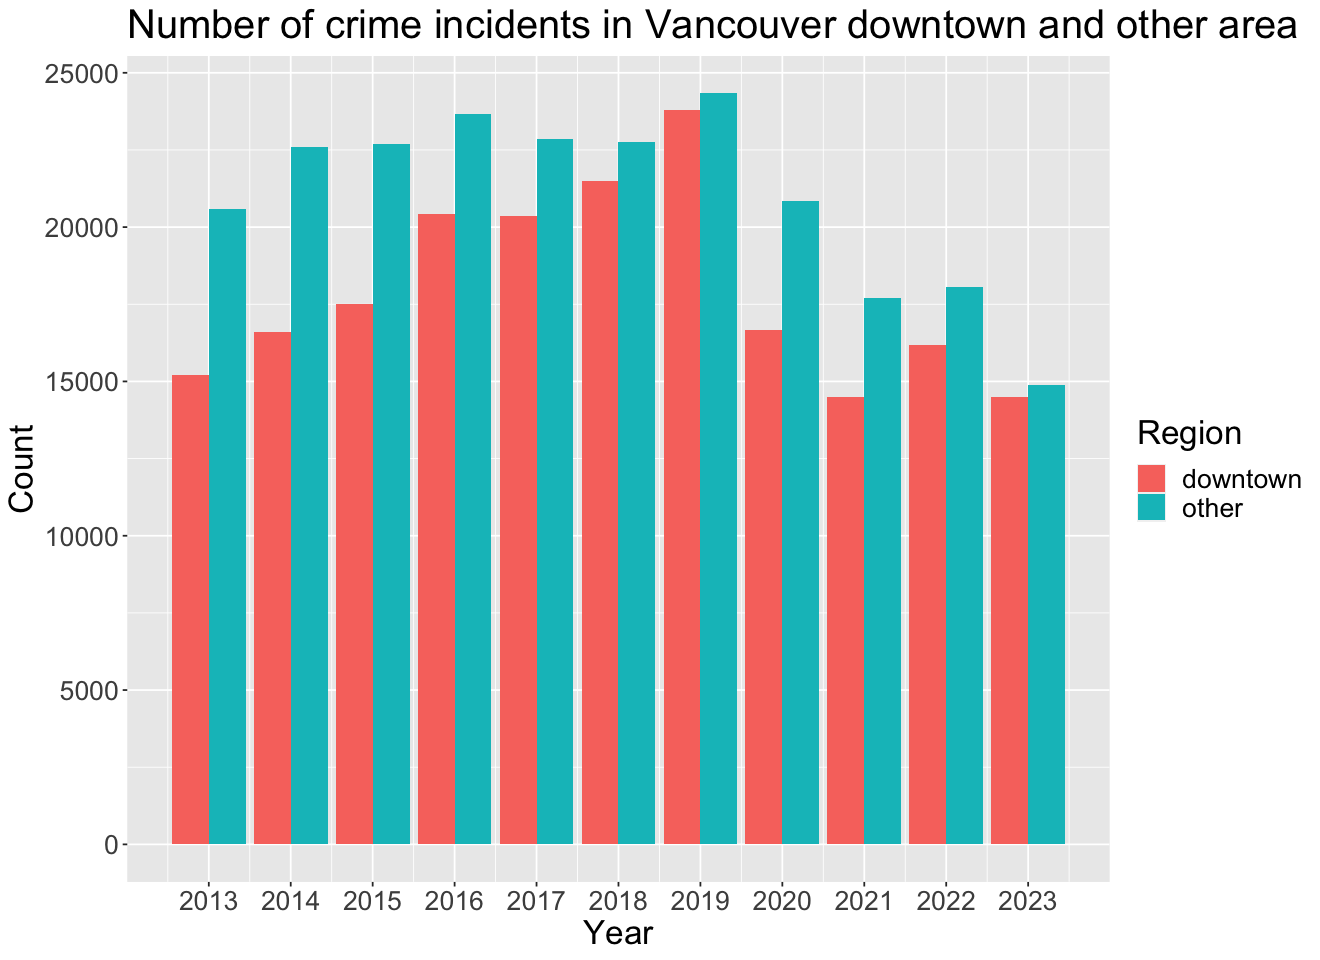

In [5]:
# visualize the count of incidents happen in two categories of area along time change
options(repr.plot.width = 11, repr.plot.height = 8)

crimedata_AllNBHD_23_13_barplot <-  criminedata_summary |>
    ggplot(aes(x = YEAR, y = count, fill = region)) +
    geom_bar(stat = "identity", position = "dodge") +
    scale_x_continuous(breaks = seq(2013,2023,1)) +
    labs(x = "Year", y = "Count", fill = "Region") +
    ggtitle("Number of crime incidents in Vancouver downtown and other area") +
    theme(text = element_text(size = 20))

crimedata_AllNBHD_23_13_barplot

In [6]:
# summarize the count of the incidents happen in night or day (time) and downtown or non downtown (region)
criminedata_downtown_summary <- crimedata_AllNBHD_23_13 |>
    group_by(YEAR) |>
    summarize(region = "downtown",
              aggregate = sum(DOWNTOWN),
              Night = sum(DOWNTOWN & NIGHT),
              Day = sum(DOWNTOWN & !NIGHT)) |>
    pivot_longer(cols = Night:Day, names_to = "time", values_to = "count")
criminedata_other_summary <- crimedata_AllNBHD_23_13 |>
    group_by(YEAR) |>
    summarize(region = "other",
              aggregate = sum(!DOWNTOWN),
              Night = sum(!DOWNTOWN & NIGHT),
              Day = sum(!DOWNTOWN & !NIGHT)) |>
    pivot_longer(cols = Night:Day, names_to = "time", values_to = "count")

crime_AllNBHD_AllTime_summary <- bind_rows(criminedata_downtown_summary, criminedata_other_summary) |>
    arrange(YEAR)

crime_AllNBHD_AllTime_summary

YEAR,region,aggregate,time,count
<int>,<chr>,<int>,<chr>,<int>
2013,downtown,15198,Night,8392
2013,downtown,15198,Day,6806
2013,other,20573,Night,10804
2013,other,20573,Day,9769
⋮,⋮,⋮,⋮,⋮
2023,downtown,14504,Night,7893
2023,downtown,14504,Day,6611
2023,other,14892,Night,8086
2023,other,14892,Day,6806


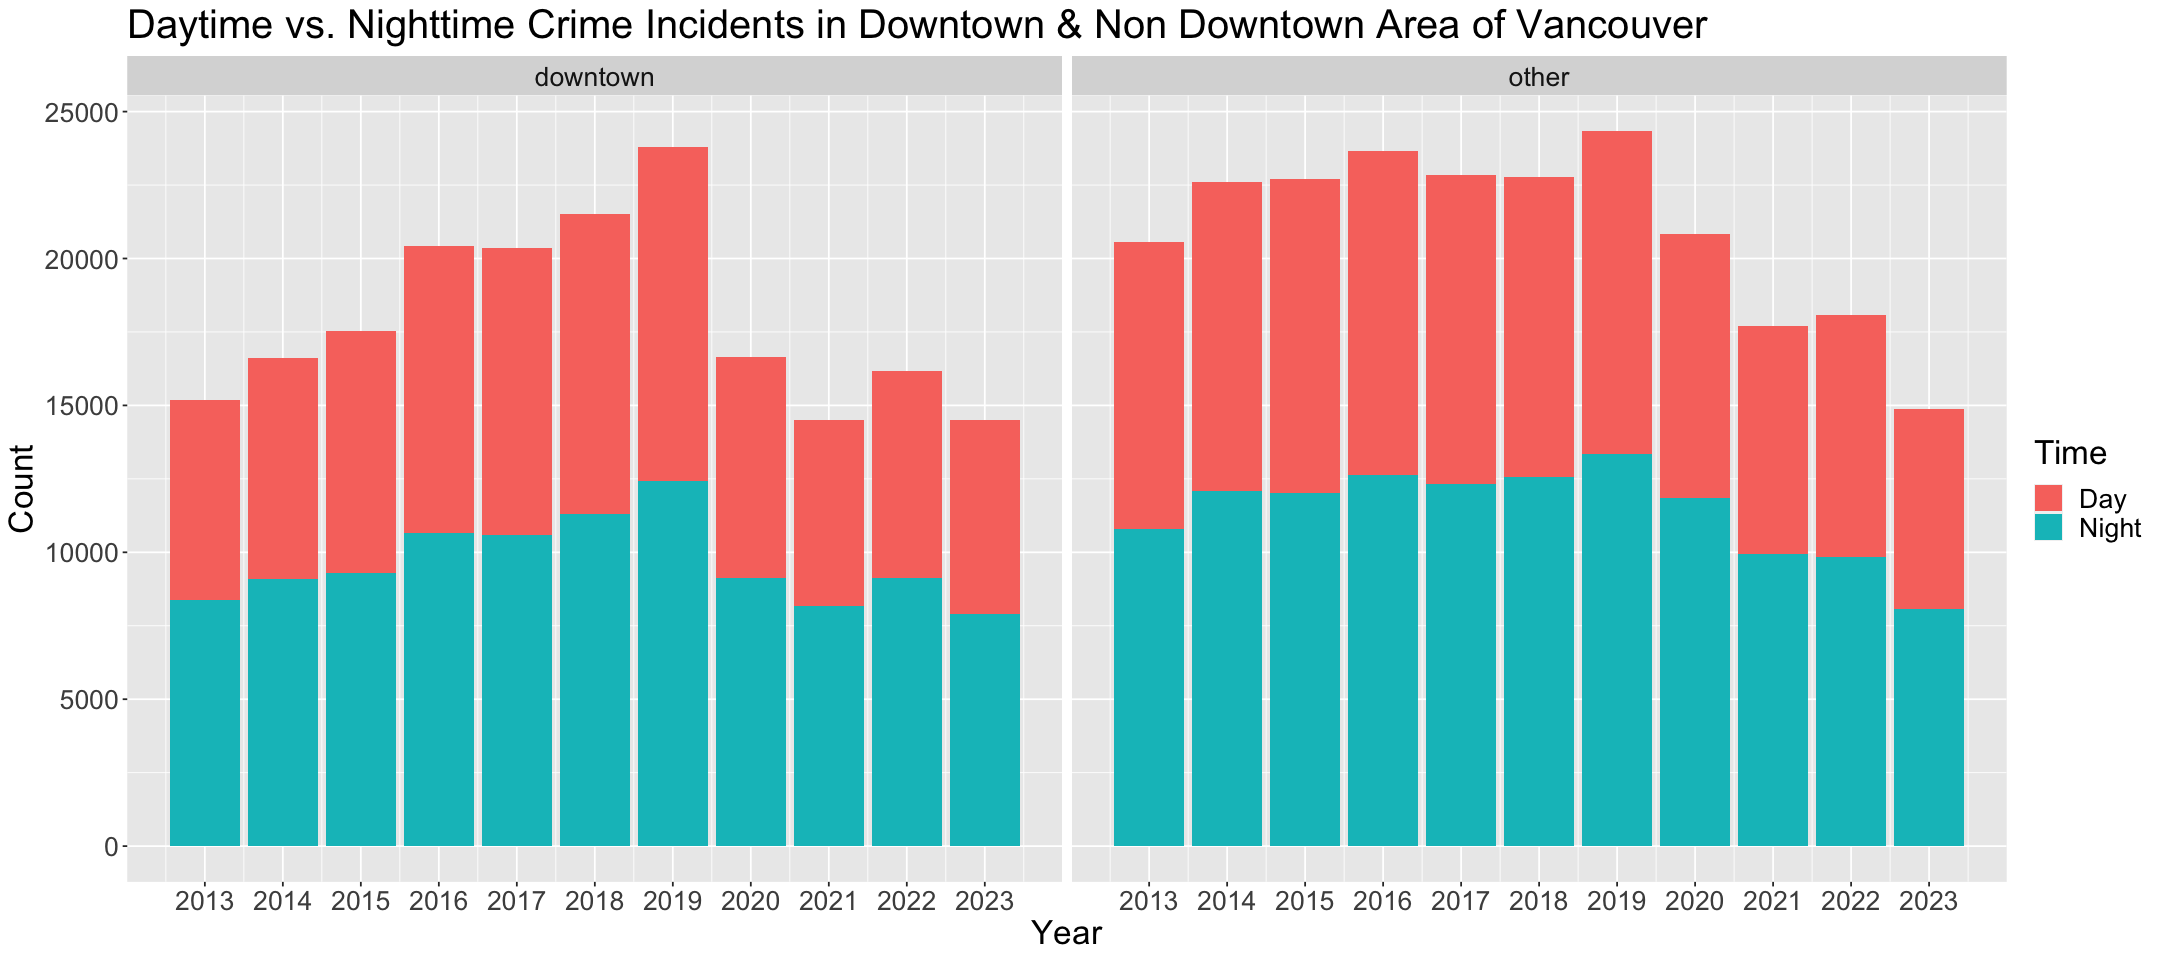

In [7]:
# visualize the count of crimes happened in the two time periods and regions along the years
options(repr.plot.width = 18, repr.plot.height = 8)

crime_AllNBHD_AllTime_summary_bar <- crime_AllNBHD_AllTime_summary |>
    ggplot(aes(x = YEAR, y = count, fill = time)) +
    geom_bar(stat = "identity") +
    scale_x_continuous(breaks = seq(2013,2023,1)) +
    labs(x = "Year", y = "Count", fill = "Time") +
    ggtitle("Daytime vs. Nighttime Crime Incidents in Downtown & Non Downtown Area of Vancouver") +
    theme(text = element_text(size = 20)) +
    facet_grid(cols = vars(region))

crime_AllNBHD_AllTime_summary_bar

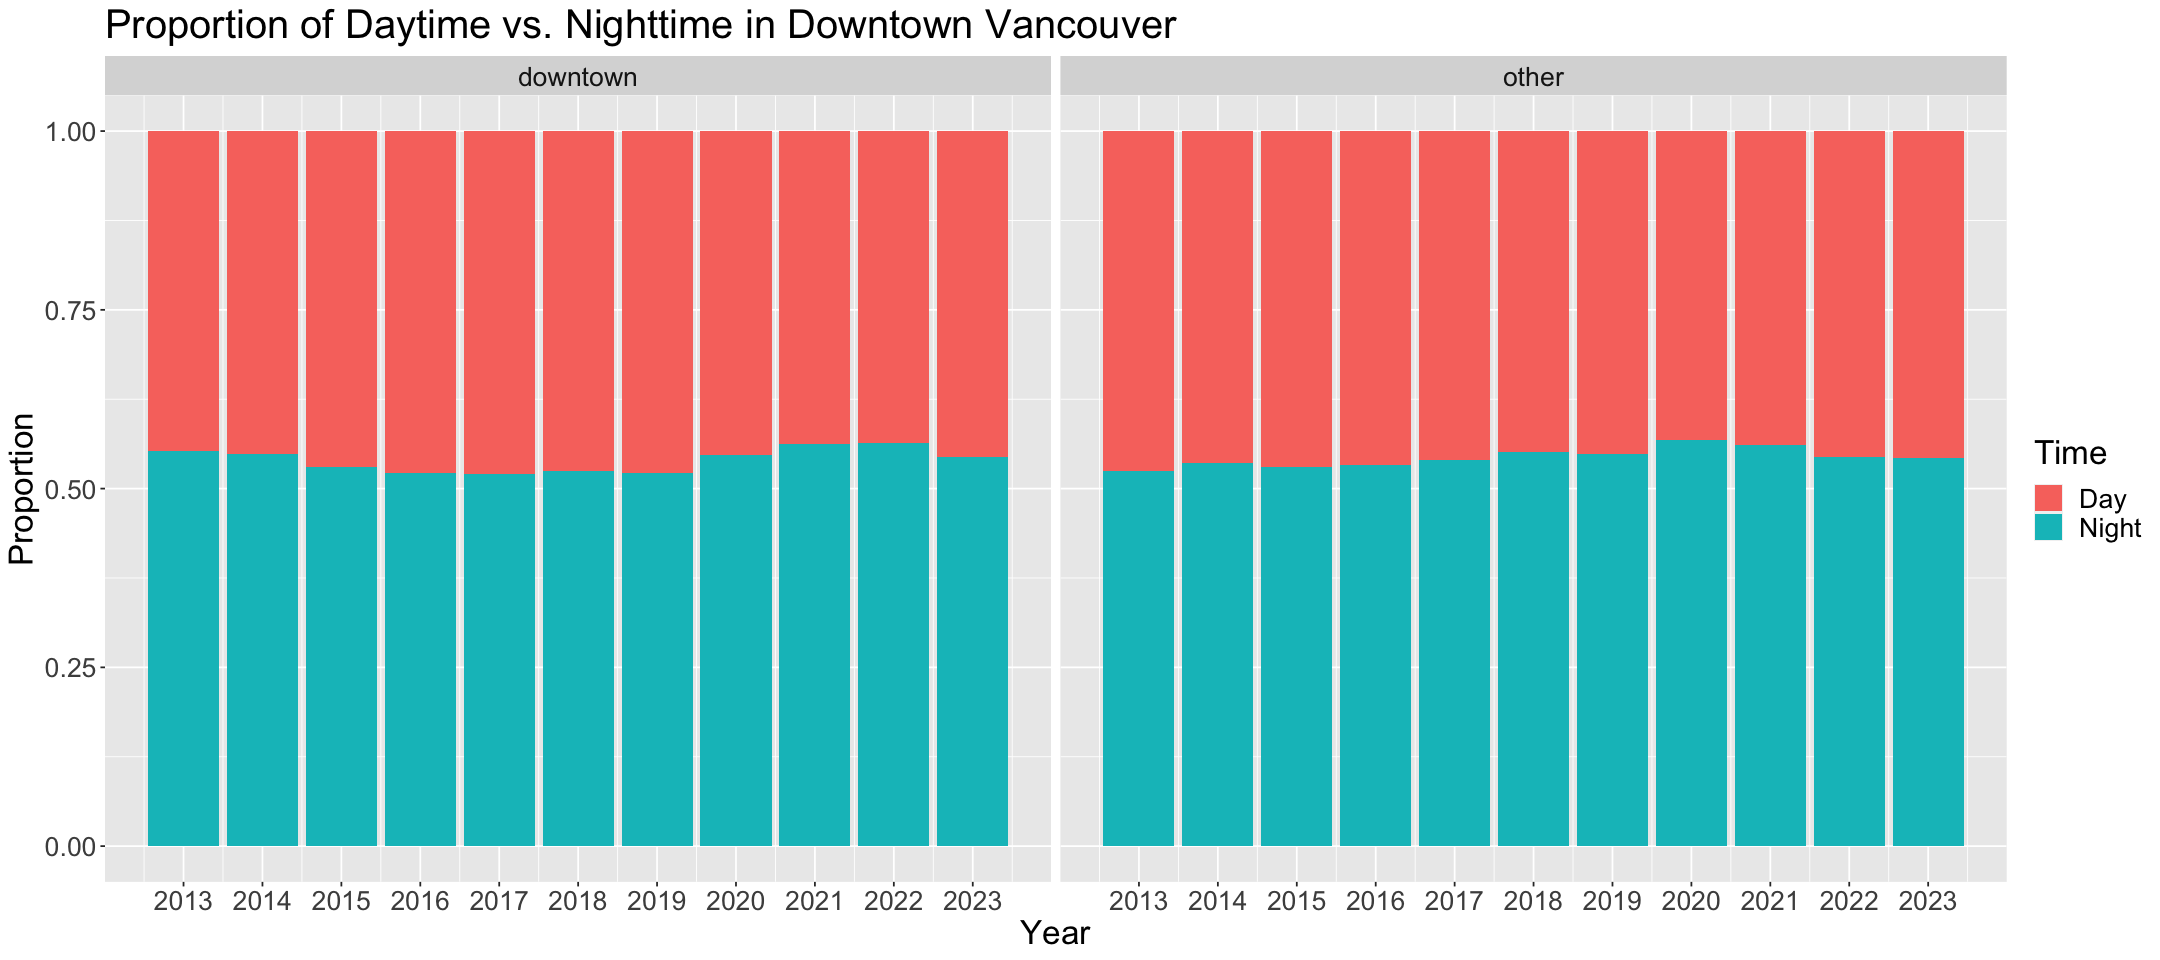

In [8]:
# visualize the proportion of the crimes happened at night or day in two regions
options(repr.plot.width = 18, repr.plot.height = 8)
crime_AllNBHD_AllTime_summary_prop <- crime_AllNBHD_AllTime_summary |>
    ggplot(aes(x = YEAR, y = count, fill = time)) +
    geom_bar(stat = "identity",position = "fill") +
    scale_x_continuous(breaks = seq(2013,2023,1)) +
    labs(x = "Year", y = "Proportion", fill = "Time") +
    ggtitle("Proportion of Daytime vs. Nighttime in Downtown Vancouver") +
    theme(text = element_text(size = 20)) +
    facet_grid(cols = vars(region))

crime_AllNBHD_AllTime_summary_prop

In [9]:
# calculate the sample statistics of average count and overall proportion for past 10 years average
crime_average <- crime_AllNBHD_AllTime_summary |>
    group_by(region, time) |>
    summarize(average = round(mean(count))) |>
    ungroup() |>
    mutate(prop = average/sum(average))

crime_average

`summarise()` has grouped output by 'region'. You can override using the
`.groups` argument.


region,time,average,prop
<chr>,<chr>,<dbl>,<dbl>
downtown,Day,8293,0.2130015
downtown,Night,9640,0.2475985
other,Day,9594,0.2464170
other,Night,11407,0.2929830


In [10]:
# since the 2023 data is not completed, we will focus on 2022 data and use as our sample
crime_sample <- crimedata_AllNBHD_23_13 |>
    filter(YEAR == 2022)

crime_sample

TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,NEIGHBOURHOOD,DOWNTOWN,NIGHT
<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<lgl>,<lgl>
Break and Enter Commercial,2022,1,5,7,34,West End,TRUE,FALSE
Break and Enter Commercial,2022,1,3,16,19,West End,TRUE,FALSE
Break and Enter Commercial,2022,6,17,5,16,West End,TRUE,TRUE
Break and Enter Commercial,2022,3,15,5,14,West End,TRUE,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Vehicle Collision or Pedestrian Struck (with Injury),2022,4,16,19,37,Renfrew-Collingwood,FALSE,TRUE
Vehicle Collision or Pedestrian Struck (with Injury),2022,9,9,18,46,Hastings-Sunrise,FALSE,TRUE
Vehicle Collision or Pedestrian Struck (with Injury),2022,8,31,20,1,Arbutus Ridge,FALSE,TRUE
Vehicle Collision or Pedestrian Struck (with Injury),2022,10,12,8,27,Mount Pleasant,FALSE,FALSE


In [11]:
# overview of sample (2022) statistics 
crime_sample_summary <- crime_sample |>
    group_by(DOWNTOWN) |>
    summarize(aggregate = n(),
              night = sum(NIGHT),
              day = sum(!NIGHT)) |>
    pivot_longer(cols = night:day, names_to = "time", values_to = "count")

crime_sample_summary

DOWNTOWN,aggregate,time,count
<lgl>,<int>,<chr>,<int>
FALSE,18070,night,9828
FALSE,18070,day,8242
TRUE,16186,night,9118
TRUE,16186,day,7068


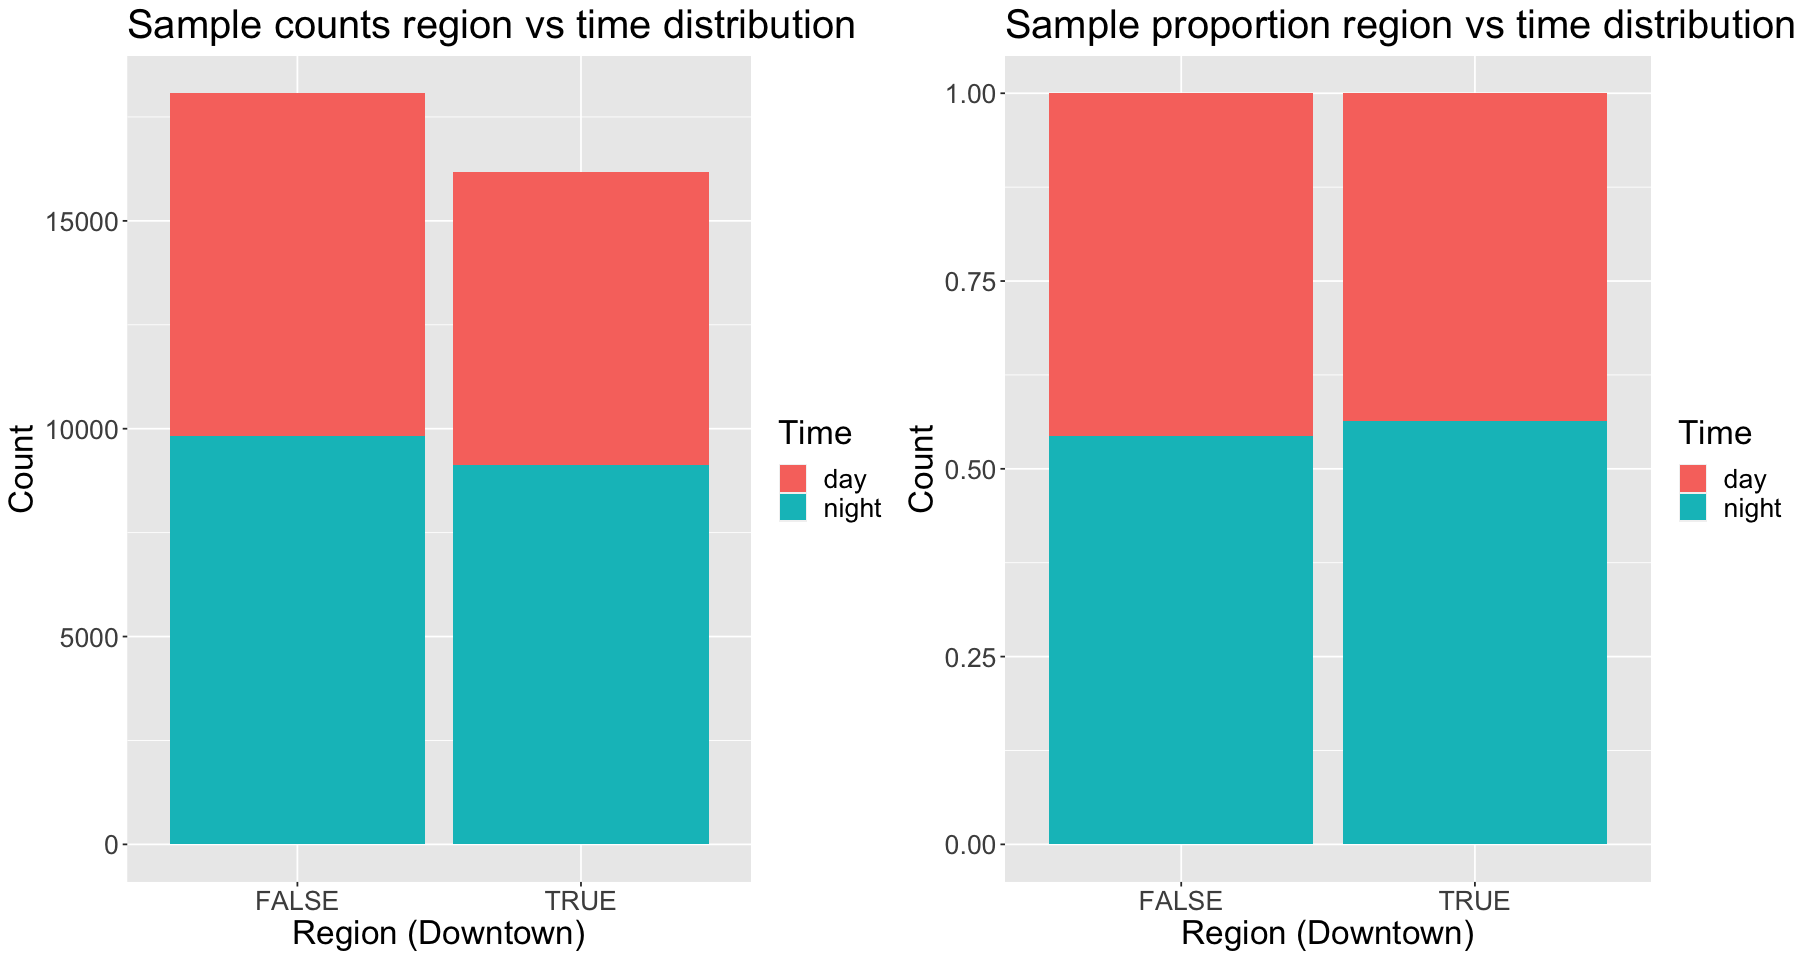

In [12]:
# visualize sample statistics distribution 

crime_sample_summary_count_dist <- crime_sample_summary |>
    ggplot(aes(x = DOWNTOWN, y = count, fill = time)) +
    geom_bar(stat = "identity") +
    labs(x = "Region (Downtown)", y = "Count", fill = "Time") +
    ggtitle("Sample counts region vs time distribution") +
    theme(text = element_text(size = 20))
crime_sample_summary_prop_dist <- crime_sample_summary |>
    ggplot(aes(x = DOWNTOWN, y = count, fill = time)) +
    geom_bar(stat = "identity", position = "fill") +
    labs(x = "Region (Downtown)", y = "Count", fill = "Time") +
    ggtitle("Sample proportion region vs time distribution") +
    theme(text = element_text(size = 20))

options(repr.plot.width = 15, repr.plot.height = 8)
plot_grid(crime_sample_summary_count_dist,
          crime_sample_summary_prop_dist,
          ncol = 2)